In [114]:
from __future__ import print_function, division

import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
import time
import os
import copy
import cv2
from util import *

plt.ion()

In [115]:
image_mean = [0.485, 0.456, 0.406]
image_std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=image_mean,
                                     std=image_std)
data_transforms = {
    TRAIN : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    VAL : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        normalize
    ]),
    TEST : transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    normalize
    ]),
}


In [116]:
train_dataset = ImageFolder(root=train_dir,
                           transform = data_transforms[TRAIN])
train_loader = DataLoader(train_dataset, 
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers = num_workers)

val_dataset = ImageFolder(root=val_dir,
                           transform = data_transforms[VAL])
val_loader = DataLoader(val_dataset, 
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers = num_workers)

test_dataset = ImageFolder(root=test_dir,
                           transform = data_transforms[TEST])
test_loader = DataLoader(test_dataset, 
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers = num_workers)

class_names = train_dataset.classes

In [117]:
def imshow(inp, title=None):
    inp = inp.transpose((1, 2, 0))
    mean = np.array(image_mean)
    std = np.array(image_std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    i = np.random.randint(1000)
    plt.imsave("confused"+str(i)+".png", inp)


# Get a batch of training data
batch_to_view = next(iter(train_loader))
inputs, classes = batch_to_view[0][:4], batch_to_view[1][:4]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

In [118]:
def get_model(model_name=RESNET50, use_cuda=True):
    model = None
    if(model_name==RESNET50):
        model = models.resnet50(pretrained=True)
        model.fc = torch.nn.Linear(in_features=2048, out_features=2)
    if(model_name==RESNET101):
        model = models.resnet101(pretrained=True)
        model.fc = torch.nn.Linear(in_features=2048, out_features=2)
    if(use_cuda):
        return model.cuda()
    else:
        return model

def get_loss_fn(use_cuda=True):
    if(use_cuda):
        return torch.nn.CrossEntropyLoss().cuda()
    else:
        return torch.nn.CrossEntropyLoss()

def get_optimizer(model, learning_rate):
    return torch.optim.SGD(
        model.fc.parameters(), learning_rate
    )

def get_lr_scheduler(optimizer, step_size = 100, gamma=0.1):
    return torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size, gamma=gamma)

def persist_model(model_state, save_path):
    torch.save(model_state, save_path)


In [119]:
class ModelMetric():
    '''class to track the avergae accuracy for the model with different datasets
    '''
    
    def __init__(self):
        self.correct_count = 0.0
        self.total_count = 0.0
        self.total_loss = 0.0
    
    def update(self, correct_count, count, loss):
        self.correct_count+=correct_count
        self.total_count+=count
        if(use_cuda):
            loss = loss.cpu().data.numpy()[0]
        else:
            loss = loss.data.numpy()[0]
        self.total_loss+=loss*count
    
    @property
    def accuracy(self):
        return self.correct_count/self.total_count
    
    @property
    def average_loss(self):
        return self.total_loss/self.total_count

In [120]:
def compute_accuracy(y_pred, labels):
    """Computes the number of correct matches in y_pred"""
    _, predictions = y_pred.topk(k = 1, dim=1)
    batch_size = labels.size(0)
    correct_count = torch.sum(predictions.eq(labels.view(-1, 1).expand_as(predictions)))
    if(use_cuda):
        correct_count = correct_count.cpu().data.numpy()[0]
    else:
        correct_count = correct_count.data.numpy()[0]
    total_count = labels.shape[0]
    return (correct_count, total_count)

In [121]:
def val(model, val_loader, loss_fn, metric):
    
    model.eval()
    start_time = time.time()
    
    for (images, labels) in val_loader:
        images = torch.autograd.Variable(images, volatile=True)
        labels = torch.autograd.Variable(labels, volatile=True)
        if(use_cuda):
            images = images.cuda()
            labels = labels.cuda()
        
        predictions = model(images)
        predictions_loss = loss_fn(predictions, labels)
        num_correct_predictions, num_total_predictions = compute_accuracy(predictions, labels)
        metric.update(num_correct_predictions, num_total_predictions, predictions_loss)
        
    print("Validation Accuracy = {}, Validation Loss = {}, Time Taken = {} seconds".format(
        metric.accuracy,
        metric.average_loss,
        time.time() - start_time
    ))
    return metric

In [122]:
def train(model, train_loader, loss_fn, optimizer, metric = None):
    running_loss = 0
    
    model.train()
    
    start_time = time.time()
    
    for (images, labels) in train_loader:
        images = torch.autograd.Variable(images)
        labels = torch.autograd.Variable(labels)
        if(use_cuda):
            images = images.cuda()
            labels = labels.cuda()
            
        predictions = model(images)
        predictions_loss = loss_fn(predictions, labels)
        num_correct_predictions, num_total_predictions = compute_accuracy(predictions, labels)
        metric.update(num_correct_predictions, num_total_predictions, predictions_loss)
        optimizer.zero_grad()
        predictions_loss.backward()
        optimizer.step()
        running_loss += predictions_loss.data[0]
        
    print("Training Accuracy = {}, Training Loss = {}, Time Taken = {} seconds".format(
        train_metric.accuracy,
        train_metric.average_loss,
        time.time() - start_time
    ))
    return metric

In [123]:
use_cuda = True
model = get_model(model_name=model_name, 
                 use_cuda=use_cuda)
loss_fn = get_loss_fn(use_cuda=use_cuda)
optimizer = get_optimizer(model=model, 
                          learning_rate=learning_rate)
lr_scheduler = get_lr_scheduler(optimizer=optimizer)

In [124]:
checkpoint = torch.load("model/checkpoint_epoch_19_val_accuracy_9880_val_loss_492.path.tar")
model.load_state_dict(checkpoint['state_dict'])

In [125]:
for (i, (images, labels)) in enumerate(val_loader):
    images = torch.autograd.Variable(images).cuda()
    break

In [126]:
model.eval()
x = images
x = model.conv1(x)
# model.train()

torch.Size([64, 3, 7, 7])


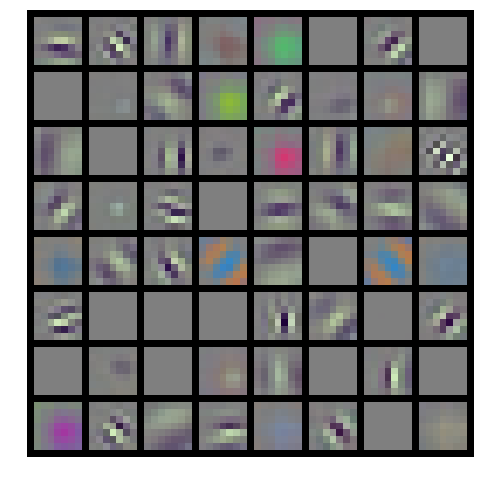

In [127]:
def visualise_tensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c,-1,w,h )
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
        
    rows = np.min( (tensor.shape[0]//nrow + 1, 64 )  )    
    grid = torchvision.utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)))

def save_tensor(tensor, filename, ch=0, allkernels=False, nrow=8, padding=2):

    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c,-1,w,h )
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)    
    torchvision.utils.save_image(tensor, filename, nrow=nrow )


ik = 0
kernel = model.conv1.weight.data.clone()
print(kernel.shape)

visualise_tensor(kernel, ch=0, allkernels=False)
save_tensor(kernel,'conv1.png', allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

torch.Size([256, 64, 1, 1])


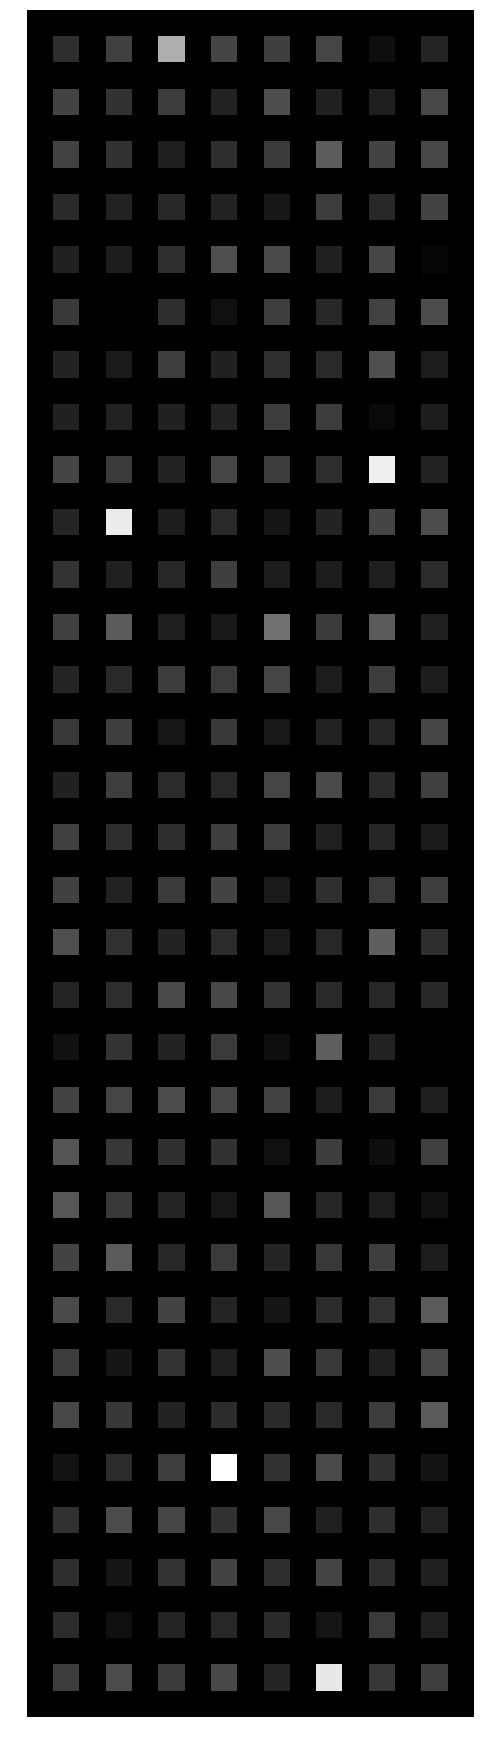

In [130]:
ik = 0
kernel = model.layer1[1].conv3.weight.data.clone()
print(kernel.shape)

visualise_tensor(kernel, ch=0, allkernels=False)
save_tensor(kernel,'laywer1.conv3.png', allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

In [95]:
ik = 0
kernel = model.layer1[1].conv1.weight.data.clone()
print(kernel.shape)

vistensor(kernel, ch=0, allkernels=False)
savetensor(kernel,'laywer1.conv1.png', allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

Bottleneck(
  (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
)